# Preliminary & Geospatial Analysis

This notebook identifies service inconsistency patterns and key relationships for modeling.

In [24]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import folium
import geopandas as gpd
from folium import plugins

# Initialize Spark session
spark = SparkSession.builder \
    .appName("TLC_Preliminary_Analysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

## Load Data and Shapefiles

In [10]:
# Load preprocessed data
daily_data = spark.read.parquet("../data/processed/daily_zone_final_2024.parquet")

# Load shapefiles
taxi_zones_gdf = gpd.read_file("../data/taxi_zones")
puma_gdf = gpd.read_file("../data/external/nypuma2020_25b")

## Service Consistency Analysis Using PySpark

In [16]:
# Calculate service consistency metrics by zone using PySpark
zone_stats = daily_data.groupBy("LocationID").agg(
    avg("daily_trips").alias("avg_trips"),
    stddev("daily_trips").alias("std_trips"),
    count("*").alias("days_count"),
    first("Median_Income").alias("income"),
    first("Borough").alias("borough"),
    first("Zone").alias("zone_name")
).withColumn("cv", col("std_trips") / col("avg_trips")) \
 .withColumn("log_avg_trips", log(col("avg_trips") + 1)) \
 .withColumn("log_income", log(col("income") + 1)) \
 .filter(col("days_count") >= 150)  # Ensure sufficient data

print(f"Service consistency calculated for {zone_stats.count()} zones")

# Identify service issues using PySpark
high_variability = zone_stats.filter(col("cv") > 1.0).count()
low_service = zone_stats.filter(col("avg_trips") < 10).count()

print(f"High variability zones (CV > 1.0): {high_variability}")
print(f"Low service zones (<10 trips/day): {low_service}")

# Overall statistics with log transforms
overall_stats = daily_data.select(
    avg("daily_trips").alias("overall_avg"),
    expr("percentile_approx(daily_trips, 0.95)").alias("p95_trips"),
    expr("percentile_approx(daily_trips, 0.05)").alias("p5_trips"),
    avg(log(col("daily_trips") + 1)).alias("log_avg_trips")
).collect()[0]

print(f"Overall trip statistics:")
print(f"  Average: {overall_stats['overall_avg']:.1f}")
print(f"  95th percentile: {overall_stats['p95_trips']:.0f}")
print(f"  5th percentile: {overall_stats['p5_trips']:.0f}")

Service consistency calculated for 229 zones
High variability zones (CV > 1.0): 5
Low service zones (<10 trips/day): 82
Overall trip statistics:
  Average: 429.0
  95th percentile: 2992
  5th percentile: 2


## Geographic Distribution of Daily Trips

Successfully merged 230 zones for visualization


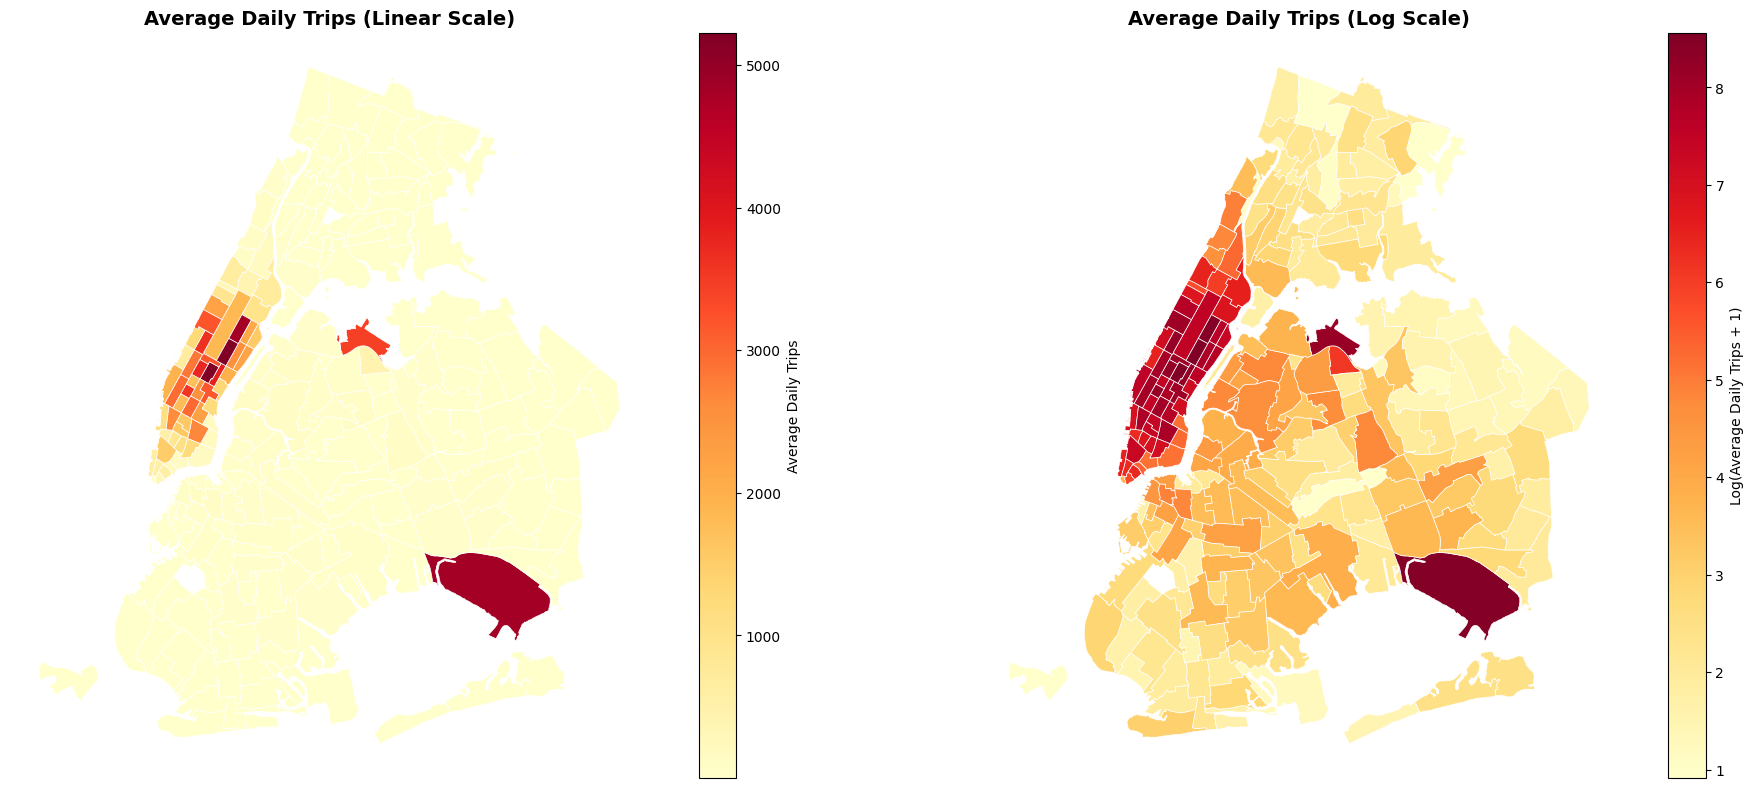

In [17]:
# Convert zone stats to pandas only for visualization
zone_stats_viz = zone_stats.toPandas()

# Merge with shapefile for mapping
zones_merged = taxi_zones_gdf.merge(zone_stats_viz, left_on='LocationID', right_on='LocationID', how='inner')
zones_merged['service_category'] = pd.cut(zones_merged['cv'], 
                                        bins=[0, 0.5, 1.0, float('inf')], 
                                        labels=['Consistent', 'Moderate', 'Inconsistent'])

print(f"Successfully merged {len(zones_merged)} zones for visualization")

# Map 1: Average daily trips by zone (log scale for better visualization)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Linear scale
zones_merged.plot(column='avg_trips', 
                  cmap='YlOrRd', 
                  legend=True,
                  legend_kwds={'label': 'Average Daily Trips'},
                  edgecolor='white',
                  linewidth=0.5,
                  ax=ax1)
ax1.set_title('Average Daily Trips (Linear Scale)', fontsize=14, fontweight='bold')
ax1.set_axis_off()

# Log scale for better pattern visibility
zones_merged.plot(column='log_avg_trips', 
                  cmap='YlOrRd', 
                  legend=True,
                  legend_kwds={'label': 'Log(Average Daily Trips + 1)'},
                  edgecolor='white',
                  linewidth=0.5,
                  ax=ax2)
ax2.set_title('Average Daily Trips (Log Scale)', fontsize=14, fontweight='bold')
ax2.set_axis_off()

plt.tight_layout()
plt.show()

## Service Consistency Geographic Pattern

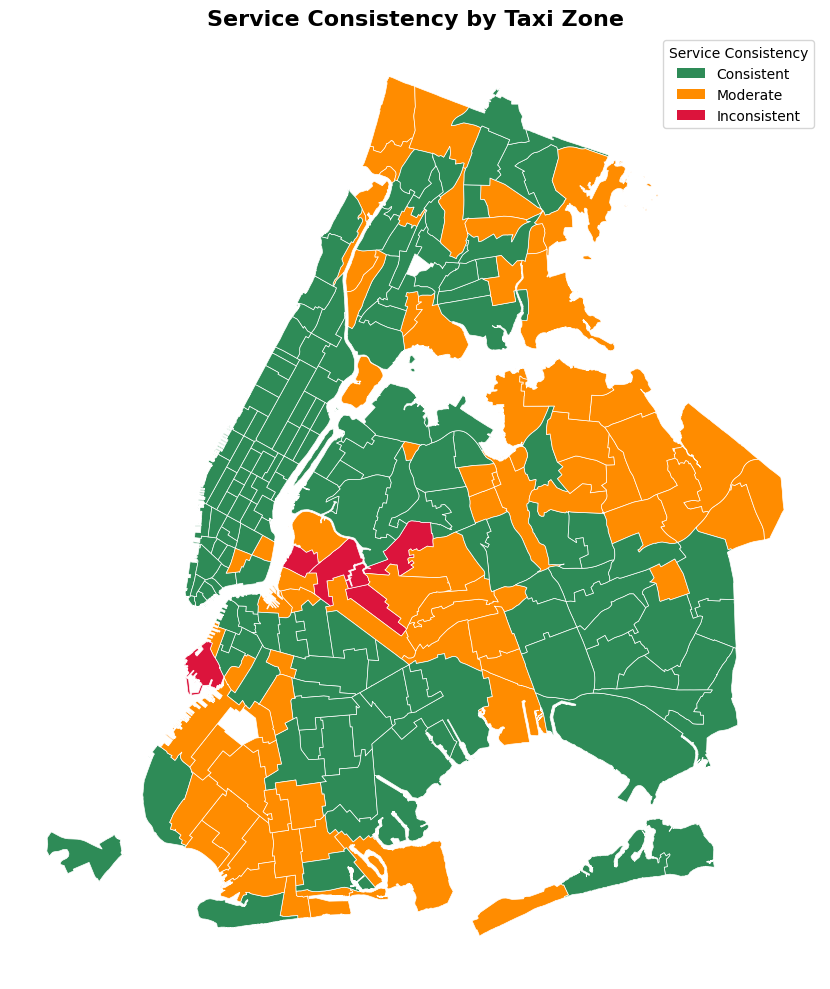

Most inconsistent zones:
+----------+--------------------+--------+------------------+------------------+
|LocationID|           zone_name| borough|         avg_trips|                cv|
+----------+--------------------+--------+------------------+------------------+
|       195|            Red Hook|Brooklyn|21.752747252747252|1.4501365109575162|
|        80|   East Williamsburg|Brooklyn| 52.63186813186813|1.1192637070031293|
|        36|      Bushwick North|Brooklyn|20.021978021978022|1.0320797160458306|
|       255|Williamsburg (Nor...|Brooklyn| 80.64285714285714|1.0319578370775557|
|       157|             Maspeth|  Queens|21.884615384615383|1.0306307506484165|
+----------+--------------------+--------+------------------+------------------+



In [18]:
# Map 2: Service consistency using PySpark-calculated metrics
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

color_map = {'Consistent': '#2E8B57', 'Moderate': '#FF8C00', 'Inconsistent': '#DC143C'}
zones_merged['color'] = zones_merged['service_category'].map(color_map)

zones_merged.plot(color=zones_merged['color'],
                  edgecolor='white',
                  linewidth=0.5,
                  ax=ax)

ax.set_title('Service Consistency by Taxi Zone', fontsize=16, fontweight='bold')
ax.set_axis_off()

# Custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[cat], label=cat) for cat in color_map.keys()]
ax.legend(handles=legend_elements, loc='upper right', title='Service Consistency')

plt.tight_layout()
plt.show()

# Show most inconsistent zones using PySpark
inconsistent_zones = zone_stats.filter(col("cv") > 1.0).orderBy(desc("cv")).limit(5)
print("Most inconsistent zones:")
inconsistent_zones.select("LocationID", "zone_name", "borough", "avg_trips", "cv").show()

## Income vs Service Analysis 

Income-Service correlations:
  Linear: 0.461
  Log-transformed: 0.484
Service by income quintile:


25/08/14 10:13:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/14 10:13:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/14 10:13:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/14 10:13:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/14 10:13:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/08/14 10:13:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+---------------+------------------+-------------------+----------+
|income_quintile|       avg_service|    avg_consistency|zone_count|
+---------------+------------------+-------------------+----------+
|              1| 259.8050751520688| 0.4262851953923999|        46|
|              2| 219.0181822803303|0.45728102296590084|        46|
|              3|26.353451908659004| 0.5135453972483391|        46|
|              4|  205.629472922663| 0.4937854041064053|        46|
|              5|1771.3139407104522|0.29040117522303044|        45|
+---------------+------------------+-------------------+----------+



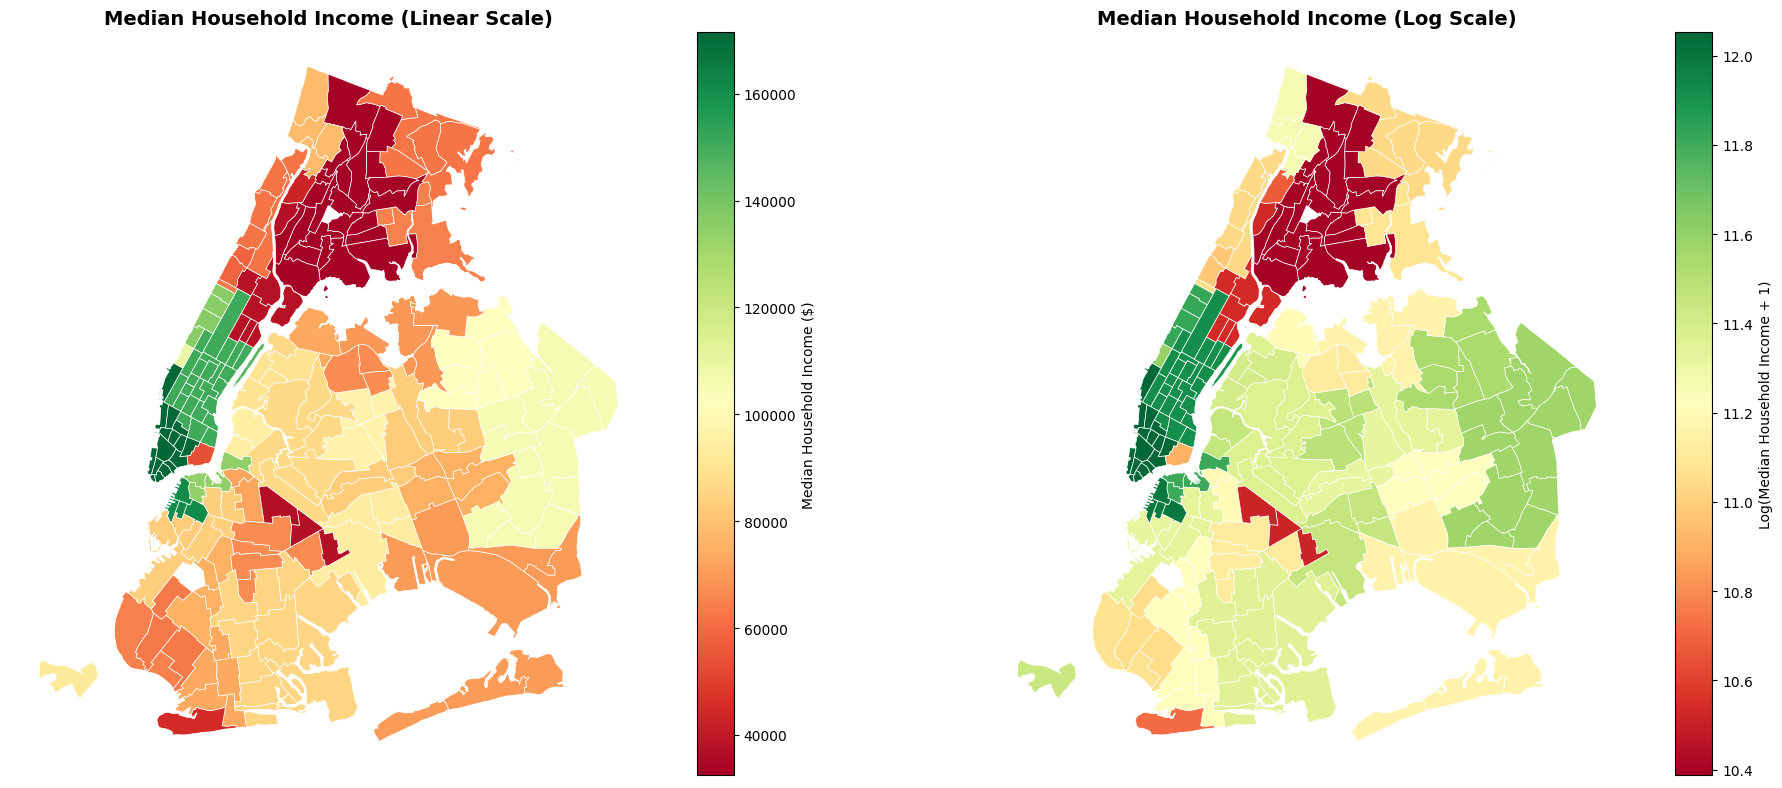

In [25]:
# Calculate income-service correlation using PySpark (both linear and log)
income_service_stats = zone_stats.select(
    corr("income", "avg_trips").alias("income_service_corr"),
    corr("log_income", "log_avg_trips").alias("log_income_service_corr")
).collect()[0]

print(f"Income-Service correlations:")
print(f"  Linear: {income_service_stats['income_service_corr']:.3f}")
print(f"  Log-transformed: {income_service_stats['log_income_service_corr']:.3f}")

# Income quintile analysis using PySpark
zone_stats_with_quintiles = zone_stats.withColumn(
    "income_quintile", 
    ntile(5).over(Window.orderBy("income"))
)

quintile_summary = zone_stats_with_quintiles.groupBy("income_quintile").agg(
    avg("avg_trips").alias("avg_service"),
    avg("cv").alias("avg_consistency"),
    count("*").alias("zone_count")
).orderBy("income_quintile")

print("Service by income quintile:")
quintile_summary.show()

# Map 3: Income distribution (log scale)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Linear scale income
zones_merged.plot(column='income', 
                  cmap='RdYlGn', 
                  legend=True,
                  legend_kwds={'label': 'Median Household Income ($)'},
                  edgecolor='white',
                  linewidth=0.5,
                  ax=ax1)
ax1.set_title('Median Household Income (Linear Scale)', fontsize=14, fontweight='bold')
ax1.set_axis_off()

# Log scale income for better visualization
zones_merged.plot(column='log_income', 
                  cmap='RdYlGn', 
                  legend=True,
                  legend_kwds={'label': 'Log(Median Household Income + 1)'},
                  edgecolor='white',
                  linewidth=0.5,
                  ax=ax2)
ax2.set_title('Median Household Income (Log Scale)', fontsize=14, fontweight='bold')
ax2.set_axis_off()

plt.tight_layout()
plt.show()

## Weather Impact Analysis 

In [32]:
# Analyze weather patterns using PySpark with actual weather features
print("Available weather features: temperature_avg, precipitation_mm, snow_mm")

# Weather correlation analysis with log-transformed trips to reduce skewness
weather_corr = daily_data.withColumn("log_daily_trips", log(col("daily_trips") + 1)).select(
    corr("precipitation_mm", "daily_trips").alias("precip_corr"),
    corr("temperature_avg", "daily_trips").alias("temp_corr"),
    corr("snow_mm", "daily_trips").alias("snow_corr"),
    corr("precipitation_mm", "log_daily_trips").alias("log_precip_corr"),
    corr("temperature_avg", "log_daily_trips").alias("log_temp_corr"),
    corr("snow_mm", "log_daily_trips").alias("log_snow_corr")
).collect()[0]

print(f"Weather correlations with trip demand:")
print(f"  Temperature (linear): {weather_corr['temp_corr']:.3f}")
print(f"  Temperature (log): {weather_corr['log_temp_corr']:.3f}")
print(f"  Precipitation (linear): {weather_corr['precip_corr']:.3f}")
print(f"  Precipitation (log): {weather_corr['log_precip_corr']:.3f}")
print(f"  Snow (linear): {weather_corr['snow_corr']:.3f}")
print(f"  Snow (log): {weather_corr['log_snow_corr']:.3f}")

# Create weather impact categories
weather_impact = daily_data.groupBy("LocationID").agg(
    avg(when(col("precipitation_mm") > 5, col("daily_trips"))).alias("heavy_rain_avg"),
    avg(when(col("precipitation_mm") <= 1, col("daily_trips"))).alias("dry_day_avg"),
    avg(when(col("snow_mm") > 0, col("daily_trips"))).alias("snow_day_avg"),
    avg(when(col("snow_mm") == 0, col("daily_trips"))).alias("no_snow_avg"),
    avg(when(col("temperature_avg") < 0, col("daily_trips"))).alias("freezing_avg"),
    avg(when(col("temperature_avg") > 25, col("daily_trips"))).alias("hot_day_avg")
).withColumn("rain_impact_pct", 
    ((col("heavy_rain_avg") - col("dry_day_avg")) / col("dry_day_avg")) * 100
).withColumn("snow_impact_pct", 
    ((col("snow_day_avg") - col("no_snow_avg")) / col("no_snow_avg")) * 100
).withColumn("cold_impact_pct", 
    ((col("freezing_avg") - col("hot_day_avg")) / col("hot_day_avg")) * 100
).filter(col("heavy_rain_avg").isNotNull())

weather_stats = weather_impact.select(
    avg("rain_impact_pct").alias("avg_rain_impact"),
    avg("snow_impact_pct").alias("avg_snow_impact"),
    avg("cold_impact_pct").alias("avg_cold_impact"),
    sum((abs(col("rain_impact_pct")) > 20).cast("int")).alias("rain_sensitive_zones"),
    sum((abs(col("snow_impact_pct")) > 20).cast("int")).alias("snow_sensitive_zones")
).collect()[0]

print(f"\nWeather impact analysis by zone:")
print(f"  Average rain impact: {weather_stats['avg_rain_impact']:.1f}%")
print(f"  Average snow impact: {weather_stats['avg_snow_impact']:.1f}%")
print(f"  Average cold weather impact: {weather_stats['avg_cold_impact']:.1f}%")
print(f"  Rain-sensitive zones (>20% change): {weather_stats['rain_sensitive_zones']}")
print(f"  Snow-sensitive zones (>20% change): {weather_stats['snow_sensitive_zones']}")

# Overall weather patterns
weather_summary = daily_data.select(
    avg("temperature_avg").alias("avg_temp"),
    avg("precipitation_mm").alias("avg_precip"),
    avg("snow_mm").alias("avg_snow"),
    sum((col("precipitation_mm") > 5).cast("int")).alias("heavy_rain_days"),
    sum((col("snow_mm") > 0).cast("int")).alias("snow_days"),
    count("*").alias("total_days")
).collect()[0]

print(f"\nOverall weather patterns (6 months):")
print(f"  Average temperature: {weather_summary['avg_temp']:.1f}°C")
print(f"  Average precipitation: {weather_summary['avg_precip']:.1f}mm")
print(f"  Average snow: {weather_summary['avg_snow']:.1f}mm")
print(f"  Heavy rain days (>5mm): {weather_summary['heavy_rain_days']}")
print(f"  Snow days: {weather_summary['snow_days']}")

Available weather features: temperature_avg, precipitation_mm, snow_mm


25/08/14 10:27:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Weather correlations with trip demand:
  Temperature (linear): 0.017
  Temperature (log): 0.047
  Precipitation (linear): 0.005
  Precipitation (log): -0.001
  Snow (linear): -0.007
  Snow (log): -0.018

Weather impact analysis by zone:
  Average rain impact: -1.0%
  Average snow impact: -22.4%
  Average cold weather impact: -24.0%
  Rain-sensitive zones (>20% change): 16
  Snow-sensitive zones (>20% change): 135

Overall weather patterns (6 months):
  Average temperature: 11.6°C
  Average precipitation: 4.0mm
  Average snow: 0.3mm
  Heavy rain days (>5mm): 20526
  Snow days: 7123


## Temporal Patterns

In [27]:
# Weekend vs weekday analysis using PySpark
weekend_patterns = daily_data.groupBy("LocationID").agg(
    avg(when(col("is_weekend") == 1, col("daily_trips"))).alias("weekend_avg"),
    avg(when(col("is_weekend") == 0, col("daily_trips"))).alias("weekday_avg")
).withColumn("weekend_ratio", 
    col("weekend_avg") / col("weekday_avg")
).filter(col("weekend_avg").isNotNull())

weekend_stats = weekend_patterns.select(
    sum((col("weekend_ratio") > 1.1).cast("int")).alias("higher_weekend"),
    sum((col("weekend_ratio") < 0.9).cast("int")).alias("lower_weekend")
).collect()[0]

print("Temporal patterns:")
print(f"  Zones with higher weekend demand: {weekend_stats['higher_weekend']}")
print(f"  Zones with lower weekend demand: {weekend_stats['lower_weekend']}")

# Monthly patterns using PySpark
monthly_patterns = daily_data.groupBy("month").agg(
    avg("daily_trips").alias("avg_monthly_trips"),
    stddev("daily_trips").alias("monthly_std"),
    avg(log(col("daily_trips") + 1)).alias("log_avg_monthly_trips")
).orderBy("month")

print("Monthly service patterns:")
monthly_patterns.show()

Temporal patterns:
  Zones with higher weekend demand: 93
  Zones with lower weekend demand: 87
Monthly service patterns:
+-----+------------------+------------------+---------------------+
|month| avg_monthly_trips|       monthly_std|log_avg_monthly_trips|
+-----+------------------+------------------+---------------------+
|    1|375.21613567403557| 931.7879827529166|   3.3250833920538665|
|    2| 405.3915288656803| 989.1935082069859|    3.392275035560137|
|    3|439.22694848084546|1063.4887570688134|    3.574457252773236|
|    4| 447.6838078583529|1089.4816942173813|    3.597237302320198|
|    5|456.48554097160485| 1125.821182582172|    3.658827597917158|
|    6|447.07621322331994| 1082.591070550331|   3.6648135296214814|
+-----+------------------+------------------+---------------------+



## Distribution Analysis with Log Transforms

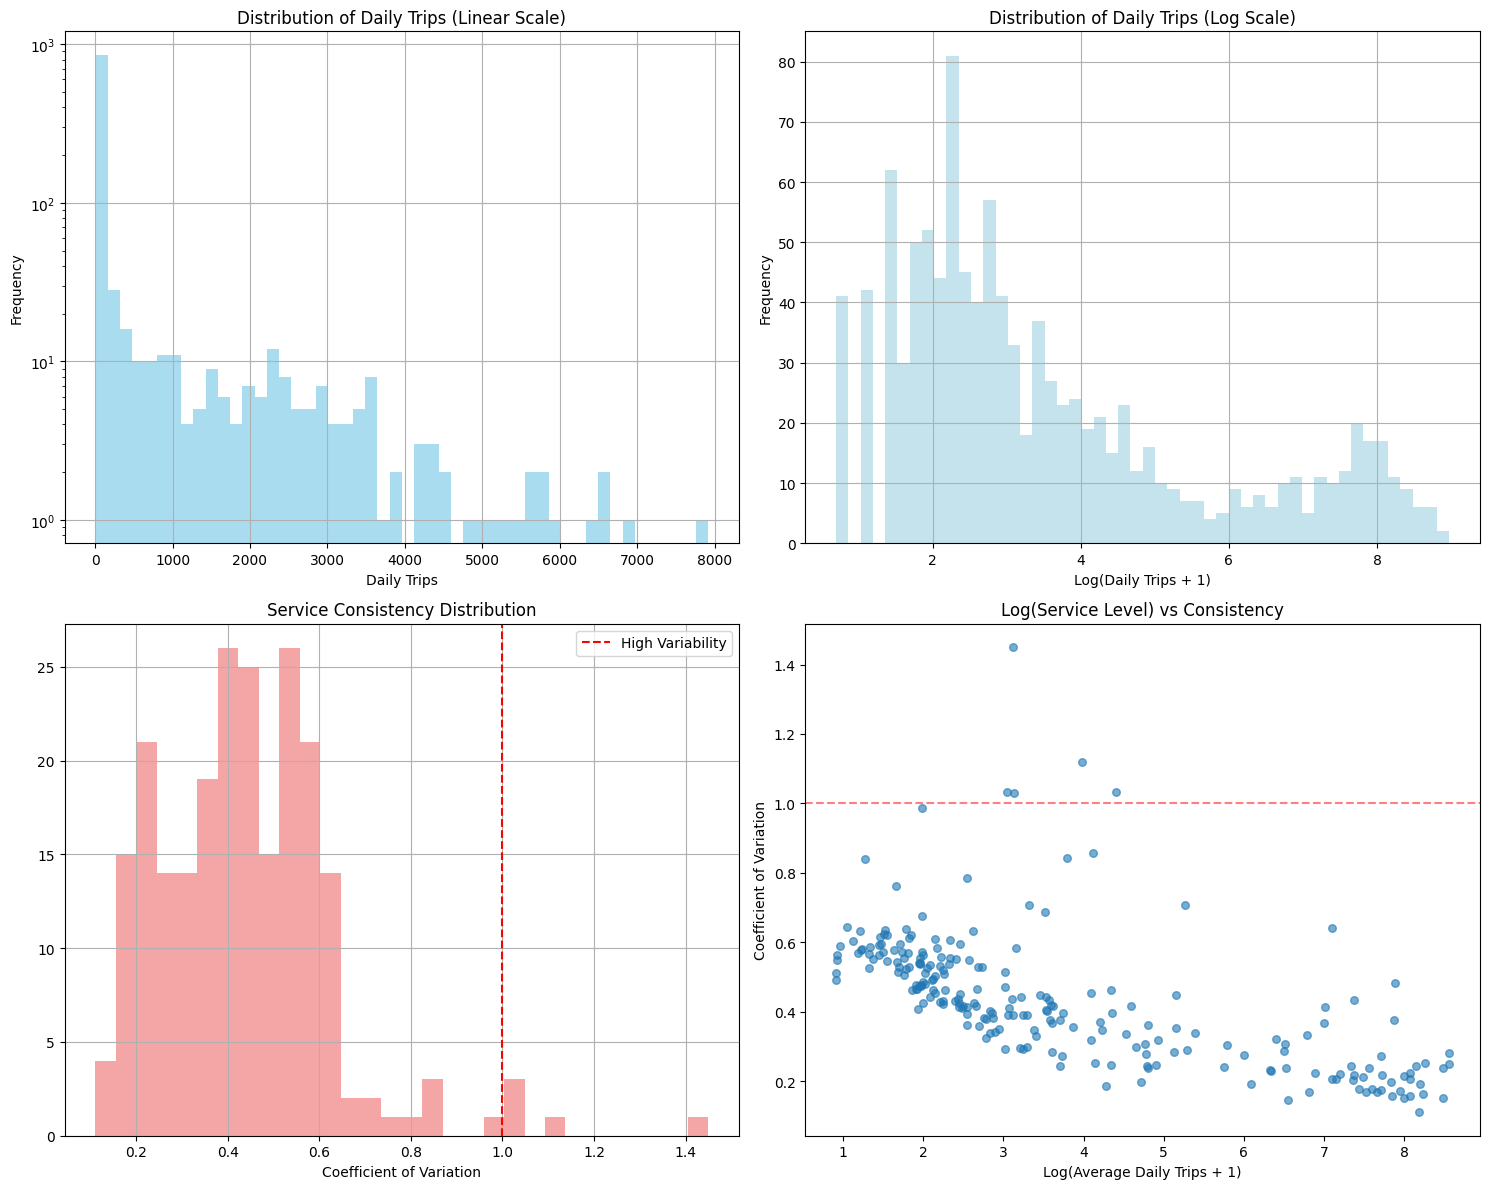

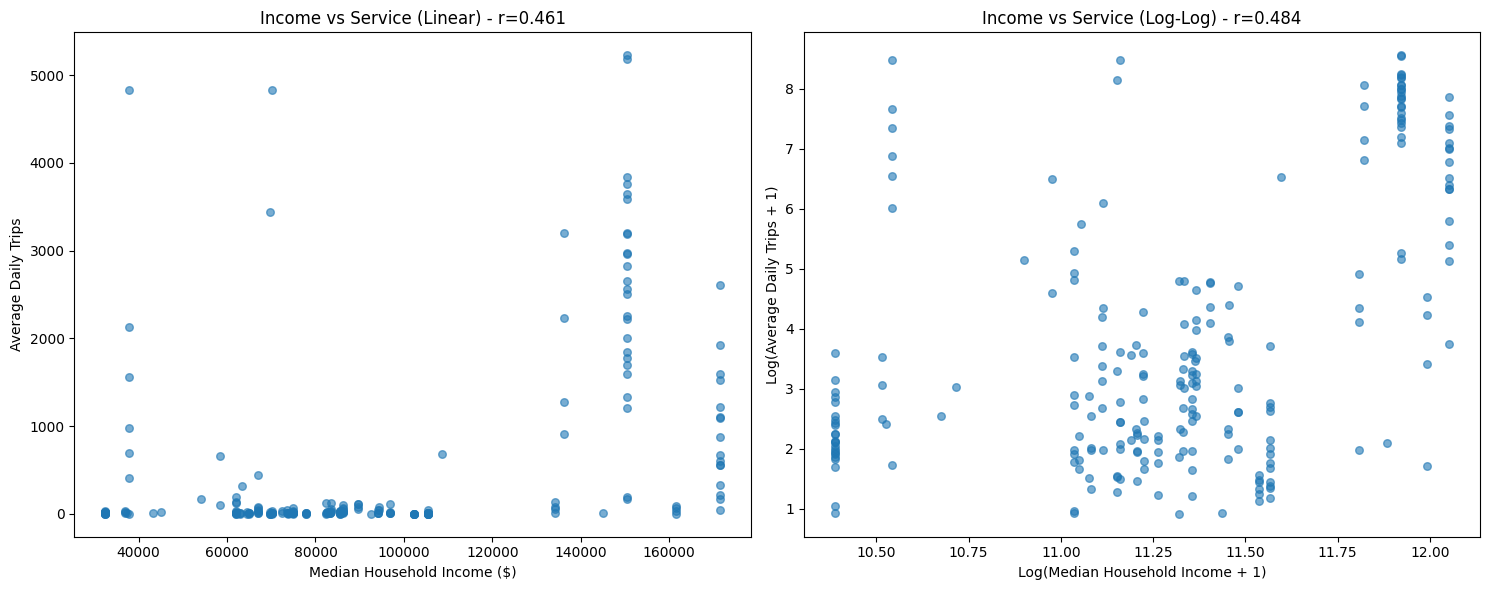

In [29]:
# Service distribution visualization with log transforms
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Get data for visualization (small samples to avoid performance issues)
trip_sample = daily_data.select("daily_trips").sample(0.01).toPandas()
zone_cv_sample = zone_stats.select("cv", "avg_trips", "log_avg_trips").toPandas()
borough_avg = daily_data.groupBy("Borough").agg(avg("daily_trips").alias("avg_trips")).toPandas()

# Distribution plots - trips (linear vs log)
trip_sample['daily_trips'].hist(bins=50, ax=ax1, alpha=0.7, color='skyblue')
ax1.set_title('Distribution of Daily Trips (Linear Scale)')
ax1.set_xlabel('Daily Trips')
ax1.set_ylabel('Frequency')
ax1.set_yscale('log')  # Log y-axis due to heavy right tail

# Log-transformed trips distribution
trip_sample['log_daily_trips'] = np.log(trip_sample['daily_trips'] + 1)
trip_sample['log_daily_trips'].hist(bins=50, ax=ax2, alpha=0.7, color='lightblue')
ax2.set_title('Distribution of Daily Trips (Log Scale)')
ax2.set_xlabel('Log(Daily Trips + 1)')
ax2.set_ylabel('Frequency')

# Service consistency distribution
zone_cv_sample['cv'].hist(bins=30, ax=ax3, alpha=0.7, color='lightcoral')
ax3.axvline(x=1.0, color='red', linestyle='--', label='High Variability')
ax3.set_title('Service Consistency Distribution')
ax3.set_xlabel('Coefficient of Variation')
ax3.legend()

# Log trips vs CV scatter (shows relationship better)
ax4.scatter(zone_cv_sample['log_avg_trips'], zone_cv_sample['cv'], alpha=0.6, s=30)
ax4.set_title('Log(Service Level) vs Consistency')
ax4.set_xlabel('Log(Average Daily Trips + 1)')
ax4.set_ylabel('Coefficient of Variation')
ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Income vs Service scatter plot (log-log scale)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Linear scale (heavily skewed)
ax1.scatter(zones_merged['income'], zones_merged['avg_trips'], alpha=0.6, s=30)
ax1.set_title(f'Income vs Service (Linear) - r={income_service_stats["income_service_corr"]:.3f}')
ax1.set_xlabel('Median Household Income ($)')
ax1.set_ylabel('Average Daily Trips')

# Log scale (better relationship visibility)
ax2.scatter(zones_merged['log_income'], zones_merged['log_avg_trips'], alpha=0.6, s=30)
ax2.set_title(f'Income vs Service (Log-Log) - r={income_service_stats["log_income_service_corr"]:.3f}')
ax2.set_xlabel('Log(Median Household Income + 1)')
ax2.set_ylabel('Log(Average Daily Trips + 1)')

plt.tight_layout()
plt.show()